<a href="https://colab.research.google.com/github/wwerkk/audio-segment/blob/main/GrainModelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title README
!yes | pip install --quiet pyfiglet

import pyfiglet
  
resulta = pyfiglet.figlet_format(f"Language Modelled Concatenative Synthesis", font = "larry3d", width = 150)
resultb = pyfiglet.figlet_format(f"v0.2", font = "larry3d")
print(resulta)
print(resultb)
print("\n")
print("\n")
print("Language Modelled Concatenative Synthesis | Author: W. K. Werkowicz | https://github.com/wwerkk | https://wwerk.notion.site")
print("Development blog | https://wwerkk.github.io")
print("\n")
print("Last Modified: 06.03.2023")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.8/865.8 KB 13.1 MB/s eta 0:00:00
 __                                                                                         __          ___    ___              __     
/\ \                                                                    /'\_/`\            /\ \        /\_ \  /\_ \            /\ \    
\ \ \         __      ___      __   __  __     __       __      __     /\      \    ___    \_\ \     __\//\ \ \//\ \      __   \_\ \   
 \ \ \  __  /'__`\  /' _ `\  /'_ `\/\ \/\ \  /'__`\   /'_ `\  /'__`\   \ \ \__\ \  / __`\  /'_` \  /'__`\\ \ \  \ \ \   /'__`\ /'_` \  
  \ \ \L\ \/\ \L\.\_/\ \/\ \/\ \L\ \ \ \_\ \/\ \L\.\_/\ \L\ \/\  __/    \ \ \_/\ \/\ \L\ \/\ \L\ \/\  __/ \_\ \_ \_\ \_/\  __//\ \L\ \ 
   \ \____/\ \__/.\_\ \_\ \_\ \____ \ \____/\ \__/.\_\ \____ \ \____\    \ \_\\ \_\ \____/\ \___,_\ \____\/\____\/\____\ \____\ \___,_\
    \/___/  \/__/\/_/\/_/\/_/\/___L\ \/___/  \/__/\/_/\/___L\ \/____/     \/_/ \/_/\/___/  \/__,_ /\/__

In [ ]:
#@title Optional: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
#@title Optional: Download audio from YouTube
youtube_url = "https://www.youtube.com/watch?v=DvbxPz0ZZPc" #@param {type:"string"}
dl_path = "audio" #@param {type:"string"}
!mkdir audio
!cd audio
!pip install yt-dlp --quiet
!yt-dlp -x "{youtube_url}" -o "{dl_path}/extracted_audio"

[youtube] Extracting URL: https://www.youtube.com/watch?v=DvbxPz0ZZPc
[youtube] DvbxPz0ZZPc: Downloading webpage
[youtube] DvbxPz0ZZPc: Downloading android player API JSON
[info] DvbxPz0ZZPc: Downloading 1 format(s): 251
[dashsegments] Total fragments: 1
[download] Destination: audio/extracted_audio
[download] 100% of    7.31MiB in 00:00:00 at 23.10MiB/s
[ExtractAudio] Destination: audio/extracted_audio.opus
Deleting original file audio/extracted_audio (pass -k to keep)


In [ ]:
#@title Install and import dependencies
!pip install --quiet mir_eval audio2numpy git+https://github.com/caillonantoine/UDLS.git@v1.0.0#egg=udls
import math
import random, numpy as np, scipy, matplotlib.pyplot as plt, sklearn, librosa
import librosa.display
import mir_eval
import IPython.display
import urllib
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Dropout
from keras.layers import LSTM, GRU
from keras.optimizers import RMSprop
import tensorflow as tf
from audio2numpy import open_audio
import os
import sys
import soundfile as sf
import pickle

  Preparing metadata (setup.py) ... done


In [ ]:
#@title TODO: load existing model and dictionary
load_existing = False #@param {type:"boolean"}
dict_path = "/content/drive/MyDrive/GrainModelling/pulse-x_dict.pkl" #@param {type:"string"}
model_path = "/content/drive/MyDrive/GrainModelling/pulse-x_model.keras" #@param {type:"string"}
if load_existing:
  with open(dict_path, 'rb') as f:
      d = pickle.load(f) # for some reason this doesn't load as it should
  model = keras.models.load_model(model_path)
#@markdown **Warning: After loading the dictionary and model you should skip to Generation**

In [34]:
#@title Load and preprocess audio
directory = "audio" #@param {type:"string"}
sample_len = 240 #@param {type:"integer"} length (s) of each sample to be taken from the dataset
fs = 24000 #@param {type:"integer"} sampling rate
augment = True #@param {type:"boolean"}
#@markdown ---
#@markdown **TODO:**\
#@markdown use the official release of udls 1.0.1 for pre-processing

### resample audio into given 
# using UDLS utility by antoine caillon
if augment:
  !resample --input {directory} --output "{directory}/preprocessed" --len {sample_len} --sr {fs} --augment
else:
  !resample --input {directory} --output "{directory}/preprocessed" --len {sample_len} --sr {fs}

### load data
audio_data = []
preprocessed_dir = directory + "/preprocessed/" + "out_" + str(fs)
for i, file in enumerate(os.listdir(preprocessed_dir)):
    x, fs = open_audio(preprocessed_dir + "/" + file)
    audio_data.append(x)
audio_data = np.array(audio_data, dtype=object)
print(audio_data.shape)

resampling extracted_audio.opus
augmenting audio_00000_00000.wav
augmenting audio_00000_00001.wav
(4,)


In [ ]:
#@title Segment
onset_detection = True #@param {type:"boolean"}
#@markdown onset settings:
backtrack = True #@param {type:"boolean"}
onset_delta = 0.089 #@param {type:"slider", min:0, max:0.5, step:0.001}
#@markdown if onset_detection is off, slice length is specified manually in seconds:
slice_length = 2 #@param {type:"integer"}
#@markdown ---
plot = False #@param {type:"boolean"}

def slice_onsets(y, sr, delta):
    slice_frames = librosa.onset.onset_detect(y=y, sr=sr, wait=0.2, backtrack=backtrack, delta=onset_delta)
    slice_samples = librosa.frames_to_samples(slice_frames)
    return slice_samples
def slice_even(y, sr, slice_length):
    hop_length = math.ceil(slice_length * fs)
    slice_samples = [* np.arange(0, len(y), slice_length)]
    return slice_samples
# segment audio into grains
if onset_detection:
    slice_samples = [slice_onsets(sample, fs, onset_delta) for sample in audio_data]
else: 
    slice_samples = [slice_even(sample, fs, slice_length) for sample in audio_data]
slice_samples = np.array(slice_samples, dtype=object)
print(slice_samples.shape)
# print(len(slice_samples[0]) + len(slice_samples[1]) + len(slice_samples[2])) # sanity check
frames = []
for s, a in zip(slice_samples, audio_data):
    # print(frame)
    # print(s, a)
    for start, end in zip(s[:-1], s[1:]):
        frames.append(a[start:end])
        # print(a[start:end])
        # print(start, end)
    try:
        frames.append(a[s[-1]:]) # append last frame
    except IndexError:
        pass
frames = np.array(frames, dtype=object)
print(frames.shape)

if plot:
  for i in range(1, frames.shape[0], int(frames.shape[0] / 3)):
      librosa.display.waveshow(frames[i], sr=fs) # display the waveform
      display(IPython.display.Audio(frames[i], rate=fs)) # play audio file using ipython display
      plt.show()

(4,)
(2778,)


In [ ]:
#@title Cluster
clustering = "kmeans"   #@param ["kmeans", "dbscan", "af"]
#@markdown if kmeans:
n_clusters = 64 #@param {type: "integer"} only applies to kmeans
#@markdown if af:
eps = 0.5 #@param {type: "number"} in case of affinity propagation
min_samples = 3 #@param {type: "integer"} in case of affinity propagation
#@markdown ---
plot = False #@param {type:"boolean"}

# Remove empty grains
frames = [frame for frame in frames if frame.size != 0]

# Extract features
def extract_features(x, fs):
    features = np.array([])
    zcr = librosa.zero_crossings(x).sum() # zero crossing rate - this corresponds to pitch
    energy = scipy.linalg.norm(x) # summed energy of each frame
    features = np.array([zcr, energy])
    if len(x) >= 2048:  
        mfccs = librosa.feature.mfcc(y=x, sr=fs, n_mfcc=13, ) # mfccs
    else:
        mfccs = librosa.feature.mfcc(y=x, sr=fs, n_mfcc=13, n_fft=len(x), hop_length=len(x))
    m_mfcc = np.median(mfccs[1:], axis=1) # first mfcc corresponds to energy which we already got, so we can ignore it
    features = np.append(features, m_mfcc) # stack everything together
    return features

features = np.array([extract_features(frame, fs) for frame in frames])
print(features.shape)
print(features[0])
min_max_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))
features_scaled = min_max_scaler.fit_transform(features)
print(features_scaled.shape)
print(features_scaled.min(axis=0))
print(features_scaled.max(axis=0))
print(features_scaled[0])
if plot:
  plt.scatter(features_scaled[:,0], features_scaled[:,1])
  plt.xlabel('Zero Crossing Rate (scaled)')
  plt.ylabel('Spectral Centroid (scaled)')    

# Classify
if clustering == "kmeans":
    c_model = sklearn.cluster.KMeans(n_clusters=n_clusters, n_init='auto')
    labels = c_model.fit_predict(features_scaled)
elif clustering == "dbscan":
    c_model = sklearn.cluster.DBSCAN(eps=eps, min_samples=min_samples)
    labels = c_model.fit_predict(features_scaled)
    labels += 1 # dbscan returns -1 for outliers, so we add 1 to all labels
else:
    c_model = sklearn.cluster.AffinityPropagation(damping=0.5, max_iter=900)
    labels = c_model.fit_predict(features_scaled)
n_labels = len(np.unique(labels))
print("n_labels:", n_labels)
len(labels)

# Store the labelled frame in a dictionary
labelled_frames = dict()
for i, label in enumerate(labels):
    if label not in labelled_frames:
        labelled_frames[label] = []
    labelled_frames[label].append(frames[i])
# print(len(labelled_frames[0])) # sanity check

def get_frame(d, label):
    return random.choice(d[label])

# preview cluster plots
if plot:
  for i in range(0, 5):
      print("------------------")
      print("Label: ", i)
      f = get_frame(labelled_frames, i)
      D = librosa.amplitude_to_db(np.abs(librosa.stft(f, hop_length=1024)),
                              ref=np.max)
      librosa.display.specshow(D, y_axis='log', sr=fs, hop_length=1024,
                          x_axis='time')
      plt.show()
      librosa.display.waveshow(f, sr=fs) # display the waveform
      plt.show()
      display(IPython.display.Audio(f, rate=fs)) # play audio file using ipython display
      plt.show()



(2776, 14)
[ 1.10100000e+03  6.83978438e-01  1.04144562e+02 -4.81641102e+00
  2.59063835e+01  5.96584034e+00  8.70654678e+00 -5.22272778e+00
  1.88455939e-01 -9.90799904e+00  3.85362005e+00 -6.44394517e-01
  4.15114594e+00 -4.04792595e+00]
(2776, 14)
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[-0.97713027 -0.99291242  0.20060973 -0.08118167 -0.21655095  0.14753901
 -0.08231631 -0.26978955 -0.32050653 -0.43680172  0.05662145 -0.23043068
 -0.12884255 -0.15478182]
n_labels: 64


In [ ]:
#@title Train model

######## TODO: Implement K-Fold validation

epochs = 2 #@param {type: "integer"} training epochs
batch_size = 32 #@param {type: "integer"} training batch size
maxlen = n_clusters # length of the input sequence window
step = 2 #@param {type: "integer"} step size for the sliding window
hidden_units = 24 #@param {type: "integer"} number of hidden units in the GRU layer
callback = False #@param {type: "boolean"}
#@markdown ---
#@markdown **TODO:**\
#@markdown K-Fold validation settings:
k_fold_on = False #@param {type: "boolean"}
k = 2 #@param {type:"integer"}
#@markdown ---
save_model = False #@param {type: "boolean"}
model_name = "guinea_model.keras" #@param {type:"string"}

# One-hot encode
# build a subsequence for every <step> frames
# and a corresponding label that follows it
features = [] # these will be features
targets = [] # these will be targets
for i in range(0, len(labels) - maxlen, step):
    features.append(labels[i: i + maxlen])
    targets.append(labels[i + maxlen])
# one-hot encode features and targets
# adapted from wandb character generation code referenced at the beginning of this notebook
encoded_features = np.zeros((len(features), maxlen, n_labels), dtype=bool)
encoded_targets = np.zeros((len(targets), n_labels), dtype=bool)
for i, sequence in enumerate(features):
    # print(i, sequence)
    for t, label in enumerate(sequence):
        encoded_features[i, t, label] = 1
        # print(encoded_features[i, t])
    encoded_targets[i, targets[i]] = 1
# sanity check
print(encoded_features.shape)
print(encoded_targets.shape)

# Build and compile model

## optional - if training on GPU
# keras.mixed_precision.set_global_policy("mixed_float16")

# adapted from wandb character generation code referenced at the beginning of this notebook
inputs = Input(shape=(maxlen, n_labels))
x = GRU(hidden_units, return_sequences=True)(inputs)
# according to DLWP [13.2.1] softmax tends to be unstable in float16
outputs = Dense(n_labels, activation='softmax', dtype="float32")(x)
model = Model(inputs=inputs, outputs=outputs)
model.compile(
    loss='sparse_categorical_crossentropy', # since we are using integer labels
    optimizer="rmsprop",
    metrics=['accuracy']
    )
model.summary()

# Callback
class SampleGrain(keras.callbacks.Callback):
    def on_epoch_end(self, batch, logs={}):
        seed = np.array([random.choice(encoded_features)])
        seq = seed
        print("\nGenerating with seed:\n", seed.astype(int))
        for temperature in [0.5, 1.2]:
            print("Temperature:\n", temperature)
            for i in range(sequence_length):
                preds = model.predict(seq, verbose=0)
                # print(preds)
                p_label = sample(preds[0], temperature)
                encoded_pred = np.eye(n_labels)[p_label].astype(bool)
                encoded_pred = np.array([[encoded_pred]])
                # print("\nPrediction: ", encoded_pred.astype(int))
                # print("\nPrediction: ", np.argmax(encoded_pred))
                # print(seed.shape, encoded_pred.shape)
                # seq = np.delete(seq, 0, axis=1)
                seq = np.concatenate((seq, encoded_pred), axis=1)
                # print("Predicted sequence:\n", seq.astype(int))
                # print("\n", seq.shape)
# Train
if callback:
  #@title Train
  model.fit(
      encoded_features,
      encoded_targets,
      batch_size=batch_size,
      epochs=epochs,
      callbacks=[SampleGrain()]
  )
else:
  model.fit(
      encoded_features,
      encoded_targets,
      batch_size=batch_size,
      epochs=epochs,

  )

# Save model
if save_model:
  model.save(model_name)

(1356, 64, 64)
(1356, 64)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64)]          0         
                                                                 
 gru_1 (GRU)                 (None, 64, 24)            6480      
                                                                 
 dense_1 (Dense)             (None, 64, 64)            1600      
                                                                 
Total params: 8,080
Trainable params: 8,080
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
43/43 [==============================] - 9s 64ms/step - loss: 2.9816 - accuracy: 0.8289
Epoch 2/2
43/43 [==============================] - 2s 43ms/step - loss: 0.4799 - accuracy: 0.9844


In [ ]:
#@title Generate sequence
sequence_length = 256 #@param {type: "integer"} no. tokens in generated sequence
temperature = 1.44 #@param {type:"slider", min:0, max:20, step:0.01}
#@markdown set to -1 for random:
seed = -1 #@param {type: "raw"}

# Sampling function
# adapted from wandb character generation code referenced at the beginning of this notebook
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')[0]
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    # print(preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

# Generate output
def generate(model, sequence_length, temperature=1.0, seed=-1):
    if seed == -1:
      seq = np.array([random.choice(encoded_features)])
    else:
      seq = np.array([(encoded_features[seed])])
    print("\nGenerating with seed:", "random" if (seed == -1) else seed, "\n", np.argmax(seq, axis=1))
    print("Temperature:\n", temperature)
    for i in range(sequence_length):
        preds = model.predict(seq, verbose=0)
        # print(preds)
        p_label = sample(preds[0], temperature)
        encoded_pred = np.eye(n_labels)[p_label].astype(bool)
        encoded_pred = np.array([[encoded_pred]])
        # print("\nPrediction: ", encoded_pred.astype(int))
        # print("\nPrediction: ", np.argmax(encoded_pred))
        # print(seed.shape, encoded_pred.shape)
        seq = np.concatenate((seq, encoded_pred), axis=1) # add the prediction to the sequence
        # print(seq.astype(int))
        # print("Predicted sequence:\n", seq.astype(int))
        # print("\n", seq.shape)
        # print("Predicted sequence:\n", seq.astype(int))
    return seq

if seed == -1:
  seq = generate(model, sequence_length=sequence_length, temperature=temperature)
else: 
  seq = generate(model, sequence_length=sequence_length, seed=seed, temperature=temperature)
g_ints = np.argmax(seq[0], axis=1)
print("Generated sequence:")
print(g_ints)
g_frames = [get_frame(labelled_frames, label) for label in g_ints]
# g_frames.shape[0] / fs


Generating with seed: random 
 [[ 0  0  2 33  0  0  3  0  0  0  0  0 12  0  0  0 61  0  0  0  0 16 15  0
   4 54  0  0  5  0  0 22  0 14 28 32  9 11  0  0  0  0  0  0 24  0  0  0
   0  0  0  0  0  0  0  0 39  0  0  0  0  0  0  0]]
Temperature:
 1.44
Generated sequence:
[ 7  7  2  6 24 28  7  7  7 36 36 37 12 12 33 22 21 21 36 37  7 24 31 21
 44 22  7 31 34 22 22 22 35  3 35 21 21 44 22 56  7  7  6  7  2 28  2  2
 37 37 37 37  2  2 25  2  2  2  6 37  2 16 28 28  9  2 43 26  1 14  6  9
 39 20 61 60 50  4 48  6 23 52 18 40 50 62 41 49 12 62 36 24 21 62 13 55
 59 25  1 38 15 59 43  4 10 48 59 51 52 63 47 50 28 43 46 63 36 55 23 36
  3  0  2 39 28 56 44 26 44 17 20 57  1 39 42 15 38 57 24 30 13 10  7 26
 44 16 25 17 54 27 44 54 36 63 45 34  8  2 53 53 36 27  3 42 15 61 45 14
  8 15  0 12  5 13 48 22 42  2 61 29 33 29 43 28 25 54 23 31 60 14 10 53
  4 14 13 21 38 38  7 28 11  8 29  1 10 24 44 25 45 57 34 39 21 55 32 40
 40  1 36 39 33 39 54  1  2  4 25 59  7 39 61 54 55 55 28 61 60 48 10 34

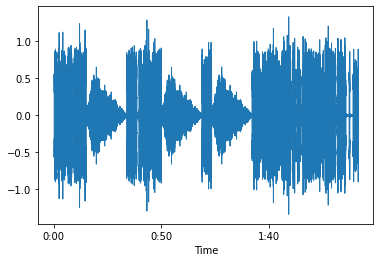

In [ ]:
#@title Resynthesise
fade_length = 0.02 #@param {type: "number"}
emitter = False #@param {type: "boolean"}
#@markdown for emitter mode:
density = 0.14375 #@param {type: "number"} grain emission rate (s) for resynthesis if emission = True
#@markdown for overlap mode:
overlap = 0.05 #@param {type: "number"} grain overlap (s) for resynthesis

def apply_fade(frame, length):
    """Apply a fade-in and fade-out to the given frame.
    frame: input frame
    length: length of fade in seconds
    """
    length = math.ceil(length * fs)
    fadein = np.arange(0, 1, 1/length)
    fadeout = 1 - fadein
    frame[:length] *= fadein
    frame[-length:] *= fadeout
    return frame

if onset_detection:
    # Apply a linear fade-in and out to each frame
    g_frames = np.array([apply_fade(frame, fade_length) for frame in g_frames], dtype=object)
else:
    # Apply a Hann window to each frame
    g_frames = np.array([frame * scipy.signal.hann(len(frame)) for frame in g_frames], dtype=object)

# Concatenate audio
def dense_concatenate(grains, fs, density):
    """ Concatenate grains with given density.
    grains: list of grains to resynthesise from
    density: density of grain emission in seconds
    """
    # Remove empty grains
    grains = [grain for grain in grains if grain.size != 0]
    max_len = np.max([(grain.shape[0]) for grain in grains])
    padded_sequence = [np.pad(grain[0], (0, max_len - grain.shape[0]), mode='constant') for grain in grains]
    print(len(padded_sequence))
    density = math.ceil(density * fs) # convert to samples
    total_len = len(grains) * density + len(grains[-1]) # total length of the output signal
    y = np.zeros(total_len) # initialize output signal
    for i, grain in enumerate(grains):
        if i == 0:
            start = 0
        else:
            start = start + density
        end = start + len(grain)
        if y[start:end].shape != grain.shape: # for debugging
            print(i, y[start:end].shape, grain.shape)
            print("OINK")
            print(y[start:end])
            y = np.pad(y, (0, grain.shape[0] - y[start:end].shape[0]), mode='constant')
        y[start:end] += np.array(grain) # add grain to output signal
        # print(i, start, end, len(grain))
    return y # return the output signal

def overlap_concatenate(grains, fs, overlap):
    """ Concatenate grains with given overlap.
    grains: list of grains to resynthesise from
    overlap: overlap between grains in seconds
    """
    # Remove empty grains
    grains = [grain for grain in grains if grain.size != 0]
    # Calculate number of samples for the overlap
    overlap_samples = int(overlap * fs)
    # Initialize the output array
    output = grains[0]
    # Iterate through the grains, starting from the second one
    for i in range(1, len(grains)):
        # Get the current grain and the previous one
        current_grain = grains[i]
        previous_grain = output[-overlap_samples:]
        # Check if current grain is shorter than the overlap
        if current_grain.shape[0] < overlap_samples:
            overlapped_samples = previous_grain[:current_grain.shape[0]] + current_grain
            output = np.concatenate((output[:-current_grain.shape[0]], overlapped_samples))
        else:
            # Sum the overlapped samples
            overlapped_samples = previous_grain + current_grain[:overlap_samples]
            # Concatenate the overlapped samples with the current grain
            output = np.concatenate((output[:-overlap_samples], overlapped_samples, current_grain[overlap_samples:]))
    return output

if emitter:
  out = dense_concatenate(g_frames, density, fs) # concatenate the grains
else:
  out = overlap_concatenate(g_frames, overlap, fs) # concatenate the grains
librosa.display.waveshow(out, sr=fs) # display the waveform
play = IPython.display.Audio(out, rate=fs) # play audio file using ipython display
IPython.display.display(play)

In [ ]:
#@title Save audio
filename = "guinea" #@param {type: "string"}
filename += f"-generation-{sequence_length}-tokens-{density}-density.wav"
output_path = "" #@param {type:"string"}
output_path += ("/" + filename)
print("Saving", output_path)
sf.write(output_path, out, fs) # write audio file to disk

Saving /pulse-x-generation-256-tokens-0.14375-density.wav


In [ ]:
#@title Save dictionary
filename = "guinea_dict" #@param {type:"string"}
output_path = "/content" #@param {type:"string"}
output_path += ("/" + filename + ".pkl")
with open(output_path, 'wb') as f:
    pickle.dump(d, f)